# Assignment 2

Use this notebook to write your code for assignment 2

# Pre-processing data

Read the data file of `shakespeare.txt` and prepare the inputs/outputs to your model.

In [1]:
from collections import defaultdict
import math
import string
import random
import re
import time


import torch
import torch.nn as nn
from torch.autograd import Variable

import unidecode
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

%matplotlib inline

In [2]:
all_characters = string.printable # list of all possible characters (from string)
num_characters = len(all_characters) # number of possible characters

text = unidecode.unidecode(open('./data/shakespeare.txt').read())
text = re.sub("\d|\n{2,}|\s{2,}","", text)

text_len = len(text) 

sequence_len = 40

def generate_sequence():
    start_index = random.randint(0, text_len - sequence_len)
    end_index = start_index + sequence_len + 1
    return text[start_index:end_index]


# Build the Model

Implement a character-based LSTM model 

In [3]:
class SimplePoet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimplePoet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers)
        
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self): 
        return (torch.zeros(1, 1, self.hidden_size),
                torch.zeros(1, 1, self.hidden_size))

In [4]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)


# Training

The main training routine

In [5]:
def generate_training_set():    
    sequence = generate_sequence()
    inp = char_tensor(sequence[:-1])
    target = char_tensor(sequence[1:])
    return inp, target

In [6]:

def evaluate_SimplePoet(character_seed='A', predict_len=100, temperature=0.8):
    
    hidden = decoder.init_hidden()
    seed_input = char_tensor(character_seed)
    predicted_string = character_seed

    for p in range(len(character_seed) - 1):
        _, hidden = decoder(seed_input[p], hidden)
    inp = seed_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        output_distribution = output.data.view(-1).div(temperature).exp()
        top_character = torch.multinomial(output_distribution, 1)[0]
        predicted_char = all_characters[top_character]
        predicted_string += predicted_char 
        inp = char_tensor(predicted_char) 
        
    return predicted_string

In [7]:

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()

    loss = 0

    for c in range(sequence_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, torch.LongTensor([target[c]]))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / sequence_len

In [8]:
def runtime(instant):
    seconds = time.time() - instant
    minutes= math.floor(seconds / 60)
    seconds -= minutes * 60
    return '%dm %ds' % (minutes, seconds)

In [9]:
num_epochs = 3000
print_every = 500 
plot_every = 10 
hidden_size = 200
num_layers = 1
learning_rate = 0.005

decoder = SimplePoet(num_characters, hidden_size, num_characters, num_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = [] 
loss_avg = 0

for epoch in range(1, num_epochs + 1):
    loss = train(*generate_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Runtime: %s, Epoch: %d (%d%%), Loss: %.4f]' % (runtime(start), epoch, epoch / num_epochs * 100, loss))
        print(evaluate_SimplePoet('Sh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every) 
        loss_avg = 0

[Runtime: 0m 19s, Epoch: 500 (16%), Loss: 2.3697]
Shae,
And fan thave adlist machig sher,
Days neir haight you is expand wames fall hap, have poped me b 

[Runtime: 0m 38s, Epoch: 1000 (33%), Loss: 1.8594]
Shat sack a alt of feall the my sumber astle for erion.
Or youlst cant, commer speect love,
Why all gl 

[Runtime: 0m 58s, Epoch: 1500 (50%), Loss: 1.8280]
Sheart
not blang death weet bangl which face timed, son till lis 'that by crought thes lame man thine  

[Runtime: 1m 17s, Epoch: 2000 (66%), Loss: 1.9491]
She ont faot should there,And what from heret for fair and worth,And I thesaurimire should and ane.
O  

[Runtime: 1m 36s, Epoch: 2500 (83%), Loss: 1.8470]
Shat hath the a their hear his the ming what beauty liffer appery for thin but that thy vange beauty f 

[Runtime: 1m 55s, Epoch: 3000 (100%), Loss: 1.6668]
Shance heir not of thy it sa thou so by altonce spelo reed me bequred have.
Lest it exsed pishould or  



# Plotting the Training Losses

Plotting the historical loss during training:

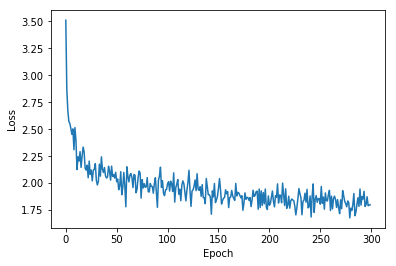

In [10]:
# Plot Loss function using "all_losses"

plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('imgs/simple_loss.png')

# Evaluating at different "temperatures"

Changing the `temperature` argument (variance) for 1.5, 0.75. 0.25 and sample outputs from the trained model.


References:
* [Shakespeare Sonnets](http://shakespeare.mit.edu/Poetry/sonnets.html)

In [11]:
print(evaluate_SimplePoet('Shall I compare thee to a summers day?\n', 300, temperature=1.5))

Shall I compare thee to a summers day?
issunce,
Ink's, to holr,-nohing thevampory.Huhgurds?Raies,
Silveluancy lonswote,
resed speliallow have rase,
Fomr zive to it
Swige: oustines it spaoul'ssuencie strial,By 'sbe shou (led in mater-svre,Sinwst mous Tim, crace:
kingsor of thee or of for ilthastar entill numeseve, dothsurt ethe (thes
Whor


In [12]:
print(evaluate_SimplePoet('Shall i compare thee to a summers day?\n', 300, temperature=0.75))

Shall i compare thee to a summers day?
By thine thee away though corns in thinged,
Or it luch what the not own what with the wellow wold) greste, (verse me the bested thee sletters thy hist so strarmed, the strange?
Like all well is the prow granles onlurst,
In wost the is, still grown ises though there forle of sway thee do grown althou


In [13]:
print(evaluate_SimplePoet('Shall i compare thee to a summers day?\n', 300, temperature=0.25))

Shall i compare thee to a summers day?
The the the the the self the the what thou the self the the self the self the so self the self the self the the state the the is strange the the the proud the seep the what is stange the self the the shall the self the self the the grown the the love the self the seep the with the leaves the of thou


# Improving the Model (SimplePoet)

1. Concatenating words and characters. (Section 4.1 Language Model)

References:

* [Deep-speare](http://aclweb.org/anthology/P18-1181)

## Concatenating words and characters

In [14]:
def process_words():
    words = []
    dline = defaultdict(list)
    avg_line = 0
    total = 0
    for line in text.splitlines():
        if len(line) > 0:
            wordup = line.split()
            words.extend(wordup)
            avg_line += len(wordup)
            total += 1
            dline[wordup[0]].append(line)
        
    avg_line = round(avg_line / total)
    unique_words = list(set(words))
    unique_words.sort()
    return unique_words, dline, avg_line
    

In [15]:
def word_tensor(sentence: list):
    tensor = torch.zeros(len(sentence)).long()
    for c in range(len(sentence)):
        tensor[c] = unique_words.index(sentence[c])
    return Variable(tensor)
    

In [16]:
def generate_word_sequence():
    
    start_index = random.randint(0, len(dlist) -1)
    items = dline[dlist[start_index]]
    choose_item = random.randint(0, len(items)-1)
    candidates = items[choose_item].split()
    
    return candidates
    

In [17]:
def generate_words_training_set():    
    sequence = generate_word_sequence()
    inp = word_tensor(sequence[:-1])
    target = word_tensor(sequence[1:])
    return inp, target

In [18]:
def generate_words_chars_training_set():
    i_0, t_0 = generate_training_set()
    i_1, t_1 = generate_words_training_set()
    inp = torch.cat((i_0, i_1),0)
    target = torch.cat((t_0, t_1),0)
    return inp, target

In [19]:
# Generate word info

unique_words, dline, avg_line = process_words()
dlist = list(dline.keys())


In [20]:
# Train the updated SimplePoet model

num_epochs = 3000
print_every = 500 
plot_every = 10 
hidden_size = 200
num_layers = 1
learning_rate = 0.005
num_items = num_characters + len(unique_words)

decoder = SimplePoet(num_items, hidden_size, num_items, num_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = [] 
loss_avg = 0

for epoch in range(1, num_epochs + 1):
    loss = train(*generate_words_chars_training_set())      
    loss_avg += loss

    if epoch % print_every == 0:
        print('[Runtime: %s, Epoch: %d (%d%%), Loss: %.4f]' % (runtime(start), epoch, epoch / num_epochs * 100, loss))
        print(evaluate_SimplePoet('Sh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every) 
        loss_avg = 0

[Runtime: 1m 17s, Epoch: 500 (16%), Loss: 2.2147]
Show she mbe rine sour that) dow as lich fire gout yur bonddisis sall pald blokight ighif kith my gric 

[Runtime: 2m 34s, Epoch: 1000 (33%), Loss: 1.7011]
Shine so that see sing, the do on of pree with out fou dune ais thate ins, men wits welfest a of misse 

[Runtime: 3m 57s, Epoch: 1500 (50%), Loss: 2.1868]
Shear thee braing ampees speas I ank necak, are the shaes my the deauth,
Whor the the wen thee be itio 

[Runtime: 5m 18s, Epoch: 2000 (66%), Loss: 1.3859]
Shat fimbed that heart of the thou ast I that theirth thintech precad thou be fimberud.
Shor's wo thee 

[Runtime: 6m 45s, Epoch: 2500 (83%), Loss: 2.0852]
Shal ages so famine come of ving from one shais with ads on quind?
For that my which youlys cones?
Wha 

[Runtime: 8m 6s, Epoch: 3000 (100%), Loss: 1.9833]
Shaen note, are, late deede,
How may.
So thought,
A pare all derver is in me thou puled dasurer I a co 



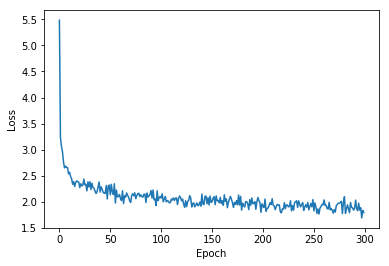

In [21]:
plt.figure()
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig("imgs/fancy_loss.png")

In [22]:
print(evaluate_SimplePoet('Shall I compare thee to a summers day?\n', 300, temperature=0.75))

Shall I compare thee to a summers day?
The a and trowe rush mate,
Mance all are shall hege, somes rede,
He resied more be rand far sumbens the recongife mode,
The jover love all deeds,
Bay though
But ple.
And shold me ald all thou mine with choull om not rackived thou beauty do hose of of mels thee.
Thou deeded do dres and that persest t
